# Compute Zonal and Meridional SST gradients in CMIP6 historical runs for one ensemble one model

In [5]:
%matplotlib inline

import xarray as xr
import intake
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import util

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [6]:
def get_zm_gradient_anom(sst,ave_yr):
  # ave_yr: specify the number of yrs for running average 
  
   # get regional mean here
    WP_mean = util.simple_spatial_average(sst, lat_bounds=[-10, 10], lon_bounds=[120, 180])
    EP_mean = util.simple_spatial_average(sst, lat_bounds=[-10, 10], lon_bounds=[220, 280])
    trop_mean = 1/2*(WP_mean + EP_mean)
    extro_mean = util.simple_spatial_average(sst, lat_bounds=[-60, -40], lon_bounds=[120, 280])
   
   # define gradient
    Tg_z = WP_mean - EP_mean
    Tg_m = trop_mean - extro_mean

   # running average
    Tg_z = Tg_z.rolling(time=12*ave_yr).mean()
    Tg_m = Tg_z.rolling(time=12*ave_yr).mean()
    
    # get anomaly w.r.t
    Tg_z_anom = Tg_z - Tg_z.mean()
    Tg_m_anom = Tg_m - Tg_m.mean()

    return Tg_z_anom, Tg_m_anom

### Get info for all models available in NCAR glade, as a reference

In [7]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

glade-cmip6-ESM Collection with 1115856 entries:
	> 17 activity_id(s)

	> 24 institution_id(s)

	> 48 source_id(s)

	> 82 experiment_id(s)

	> 163 member_id(s)

	> 35 table_id(s)

	> 1029 variable_id(s)

	> 12 grid_label(s)

	> 59 dcpp_init_year(s)

	> 251 version(s)

	> 7799 time_range(s)

	> 1115856 path(s)

In [8]:
# print out the names of all experiments/models/tables
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 82,
                   'values': ['ssp370', 'histSST-piNTCF', 'histSST',
                              'histSST-1950HC', 'hist-1950HC', 'hist-piNTCF',
                              'piClim-NTCF', 'ssp370SST-lowNTCF',
                              'ssp370-lowNTCF', 'ssp370SST', '1pctCO2-bgc',
                              'hist-bgc', 'esm-ssp585', '1pctCO2-cdr',
                              'amip-future4K', 'amip-m4K', 'a4SST', 'aqua-p4K',
                              'piSST', 'amip-4xCO2', 'a4SSTice', 'amip-p4K',
                              'aqua-control', 'aqua-4xCO2', 'abrupt-4xCO2',
                              'historical', 'piControl', 'amip', '1pctCO2',
                              'esm-hist', 'esm-piControl', 'ssp245', 'ssp585',
                              'ssp126', 'hist-GHG', 'hist-aer', 'hist-nat',
                              'dcppA-hindcast', 'dcppC-hindcast-noPinatubo',
                              'dcppC-hindcast-noElChichon', 'dcppA-

## Pick out models that have target variables 
- ts: surface temperature (Amon)
- sftlf: land area fraction (fx)

In [9]:
models = set(uni_dict['source_id']['values']) # all the models

for experiment_id in ['historical']:
    query = dict(experiment_id=experiment_id, table_id='Amon', 
                 variable_id=['ts','sftlf'])  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

# to eliminate some models
#models = models - {'CESM2-WACCM', 'CESM2'}

models = list(models)
print(len(models),' models')
models

26  models


['CanESM5',
 'MCM-UA-1-0',
 'CNRM-CM6-1',
 'FGOALS-g3',
 'CNRM-ESM2-1',
 'EC-Earth3',
 'UKESM1-0-LL',
 'CAMS-CSM1-0',
 'E3SM-1-0',
 'GFDL-CM4',
 'HadGEM3-GC31-LL',
 'MIROC-ES2L',
 'GISS-E2-1-H',
 'MIROC6',
 'BCC-ESM1',
 'SAM0-UNICON',
 'MRI-ESM2-0',
 'IPSL-CM6A-LR',
 'GISS-E2-1-G',
 'GFDL-ESM4',
 'CESM2',
 'BCC-CSM2-MR',
 'EC-Earth3-Veg',
 'NESM3',
 'NorESM2-LM',
 'CESM2-WACCM']

## read historical ts from one model one ensemble 

In [10]:
model_x = 'CESM2'
member_x='r1i1p1f1'
experiment_x = 'historical'

#### first get land-sea mask

In [11]:
# land-sea mask
cat_fx = col.search(experiment_id=experiment_x, member_id = member_x,source_id=model_x, variable_id='sftlf', table_id='fx', grid_label='gn')
cat_fx.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
98822,CMIP,NCAR,CESM2,historical,r1i1p1f1,fx,sftlf,gn,NaN,v20190308,NaN,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...


In [12]:
dset_dict_fx = cat_fx.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': True})
dset_dict_fx.keys()



xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


dict_keys(['CMIP.NCAR.CESM2.historical.fx.gn'])

In [13]:
if len(dset_dict_fx.keys()) == 1: 
    for key in dset_dict_fx.keys():
        da_fx = dset_dict_fx[key]

#da_fx = dset_dict_fx['ScenarioMIP.MIROC.MIROC6.ssp585.fx.gn']

#### then ready to read [ts]

In [14]:
table_x = ['Amon']
variable_x = ['ts']

cat = col.search(experiment_id=experiment_x, 
                 table_id= table_x , 
                 member_id=member_x,
                 variable_id=variable_x, 
                 source_id=model_x) #time_range = '185001-201412'
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
98982,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,ts,gn,NaN,v20190308,185001-201412,/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/...


In [99]:
# if go for all ensembels, check here, if not, skipp
en_dict = cat.df.member_id.unique()
en_dict

array(['r2i1p1f1', 'r5i1p1f1', 'r1i1p1f1', 'r4i1p1f1', 'r3i1p1f1',
       'r9i1p1f1', 'r8i1p1f1', 'r10i1p1f1', 'r7i1p1f1', 'r6i1p1f1'],
      dtype=object)

In [15]:
# read in as dataset structure 
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': True}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': True})


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 1 group(s)


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [16]:
dset_dict.keys()

dict_keys(['CMIP.NCAR.CESM2.historical.Amon.gn'])

In [17]:
if len(dset_dict.keys()) == 1: 
    for key in dset_dict.keys():
        da_ts = dset_dict[key]

#da_ts = dset_dict['ScenarioMIP.MIROC.MIROC6.ssp585.Amon.gn']

In [18]:
# #*** if 'decode_times': False ****
# assign new time accordinates to date

# import datetime
# def get_initial_date(t0):
#     new_date = datetime.datetime(1,1,1,0,0) + datetime.timedelta(t0 - 1)
#     return new_date.strftime("%Y-%m-%d")

# date0 = get_initial_date(da_ts.time[0].values)
# times = pd.date_range(date0, periods=len(da_ts.time), freq='MS')
# da_sst = da_ts.assign_coords(time = times)


# #*** if 'decode_times': True ***
da_sst = da_ts


In [19]:
da_sst

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, member_id: 1, nbnd: 2, time: 1980)
Coordinates:
  * member_id  (member_id) <U8 'r1i1p1f1'
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    ts         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    case_id:                15
    cesm_casename:          b.e21.BHIST.f09_g17.CMIP6-historical.001
    contact:              

In [155]:
# if da_sst (Dataset) has member_id > 1 (multi ensembles)
#  --- get ensemble-mean here

da_sst = da_sst.mean(dim = 'member_id')

In [20]:
# take out ocean TS as SST, and convert to deg C

sst = da_sst.ts.where(da_fx.sftlf== 0)-273.15
#sst = da_sst.ts-273.15

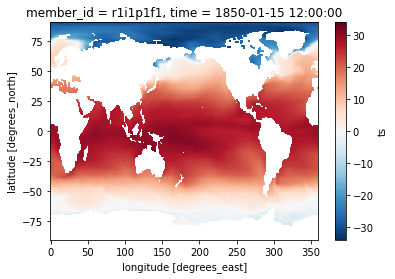

In [22]:
# make sure the land-sea mask works
sst.isel(time=0).plot()

In [116]:
sst

<xarray.DataArray 'ts' (time: 1980, lat: 128, lon: 256, member_id: 1)>
dask.array<sub, shape=(1980, 128, 256, 1), dtype=float32, chunksize=(1200, 128, 256, 1), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat        (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'

In [44]:
#sst

### Ready to move to regional averages

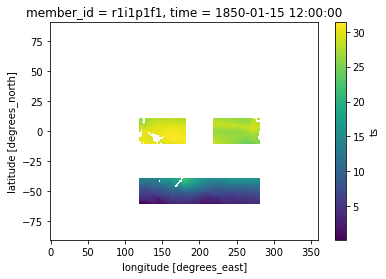

In [23]:
# plot to see the box selected

#sst.isel(time = 0).sel(lat=slice(-20, 20),lon=slice(100, 120)).plot()
lat = sst.lat
lon = sst.lon

# fig, axes = plt.subplots(ncols=3,figsize= (14,5))
# sst.isel(time = 0).where((lat>=-10) & (lat<=10) & (lon>=120) & (lon<=180)).plot(ax=axes[0])
# sst.isel(time = 0).where((lat>=-10) & (lat<=10) & (lon>=220) & (lon<=280)).plot(ax=axes[1])
# sst.isel(time = 0).where((lat>=-60) & (lat<=-40) & (lon>=120) & (lon<=280)).plot(ax=axes[2])

# one axis with three plots
# sst.isel(time = 0).where((lat>=-10) & (lat<=10) & (lon>=120) & (lon<=180)).plot()
# sst.isel(time = 0).where((lat>=-10) & (lat<=10) & (lon>=220) & (lon<=280)).plot()
# sst.isel(time = 0).where((lat>=-60) & (lat<=-40) & (lon>=120) & (lon<=280)).plot()

wp = (lat>=-10) & (lat<=10) & (lon>=120) & (lon<=180)
ep = (lat>=-10) & (lat<=10) & (lon>=220) & (lon<=280)
so = (lat>=-60) & (lat<=-40) & (lon>=120) & (lon<=280)

sst.isel(time = 0).where(wp | ep | so).plot()

In [159]:
# get regional mean here
WP_mean = util.simple_spatial_average(sst, lat_bounds=[-10, 10], lon_bounds=[120, 180])
EP_mean = util.simple_spatial_average(sst, lat_bounds=[-10, 10], lon_bounds=[220, 280])
trop_mean = 1/2*(WP_mean + EP_mean)
extro_mean = util.simple_spatial_average(sst, lat_bounds=[-60, -40], lon_bounds=[120, 280])

# define gradient
Tg_z = WP_mean - EP_mean
Tg_m = trop_mean - extro_mean

# running average
Tg_z = Tg_z.rolling(time=12*5).mean()
Tg_m = Tg_z.rolling(time=12*5).mean()

# get anomaly w.r.t
Tg_z_anom = Tg_z - Tg_z.mean()
Tg_m_anom = Tg_m - Tg_m.mean()



/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [24]:
Tg_z_anom,Tg_m_anom = get_zm_gradient_anom(sst,5)

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


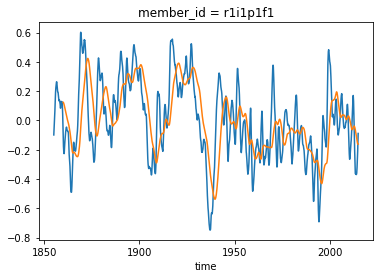

In [25]:

Tg_z_anom.plot()
Tg_m_anom.plot()

In [125]:
Tg_z_anom

<xarray.DataArray (time: 1980, member_id: 1)>
dask.array<sub, shape=(1980, 1), dtype=float64, chunksize=(1200, 1), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'

In [126]:
Tg_m_anom

<xarray.DataArray (time: 1980, member_id: 1)>
dask.array<sub, shape=(1980, 1), dtype=float64, chunksize=(1200, 1), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f1'